# Plant Seedlings Classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = './data/plant-seedlings/'
arch = resnet50
sz = 224
bs = 32

In [ ]:
label_csv = f'{PATH}labels.csv'

n = len(list(open(label_csv)))-1

val_idxs = get_cv_idxs(n)

# Data Transform

In [6]:
def get_data(sz, bs, val):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', test_name='test',
                                    val_idxs=val, tfms=tfms, bs=bs)
    return data

# Find Learning Rate

In [7]:
data = get_data(sz,bs,val_idxs)

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 25/25 [00:06<00:00,  3.95it/s]


In [9]:
lrf = learn.lr_find()

 79%|███████▉  | 94/119 [00:01<00:00, 85.08it/s, loss=2.3] 


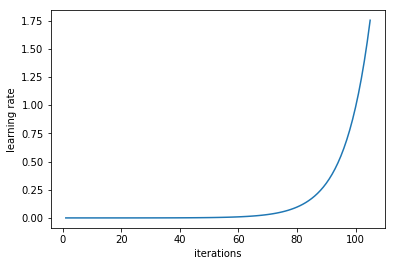

In [10]:
learn.sched.plot_lr()

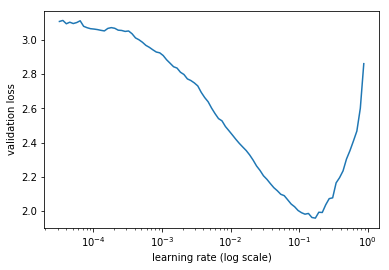

In [11]:
learn.sched.plot()

In [12]:
lr = 1e-2

# Improve Model

In [13]:
learn.fit(lr,1)

epoch      trn_loss   val_loss   accuracy                  
    0      1.044057   0.642807   0.776842  



[array([0.64281]), 0.7768421054513831]

In [14]:
learn.precompute = False

In [15]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.775078   0.522966   0.828421  
    1      0.680685   0.461171   0.841053                    
    2      0.634663   0.431705   0.844211                    



[array([0.4317]), 0.8442105266922398]

In [16]:
learn.save('resnet50_224_lastlayer')

In [17]:
learn.load('resnet50_224_lastlayer')

In [18]:
learn.unfreeze()

In [19]:
lrs=np.array([lr/18,lr/6,lr/2])

In [20]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.419979   0.212264   0.927368  
    1      0.296231   0.163813   0.933684                    
    2      0.190245   0.141543   0.946316                    
    3      0.205923   0.152013   0.94                        
    4      0.17334    0.120731   0.962105                    
    5      0.129524   0.107817   0.961053                    
    6      0.104211   0.111951   0.957895                    



[array([0.11195]), 0.9578947365911383]

In [23]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9610526315789474, 0.11185321260727417)

In [21]:
learn.save('resnet50_224_all')

In [22]:
learn.load('resnet50_224_all')

# Increase Data Image Size

In [24]:
sz = 320

In [25]:
data = get_data(sz,bs,val_idxs)
learn.set_data(data)

In [26]:
learn.freeze()

In [27]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.087575   0.108917   0.965263  
    1      0.081115   0.109826   0.961053                     
    2      0.079157   0.110314   0.962105                     



[array([0.11031]), 0.9621052636598286]

In [28]:
learn.save('resnet50_320_last_layer')

In [29]:
learn.load('resnet50_320_last_layer')

In [30]:
learn.unfreeze()

In [31]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.109061   0.111816   0.966316  
    1      0.120467   0.145467   0.951579                    
    2      0.091463   0.108905   0.967368                     
    3      0.102034   0.118434   0.962105                     
    4      0.10501    0.117613   0.949474                     
    5      0.068362   0.104145   0.965263                     
    6      0.068308   0.101373   0.971579                     



[array([0.10137]), 0.971578947619388]

In [32]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9768421052631578, 0.08178078613718429)

In [33]:
learn.save('resnet50_320_all')

In [34]:
learn.load('resnet50_320_all')

# Train with Everything

In [35]:
# Move all validation data except one (due to fastai limitation) to training data
data = get_data(sz,bs,[0])
learn.set_data(data)

In [37]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.097956   3.9e-05    1.0       
    1      0.080416   4e-05      1.0                          
    2      0.083061   3.1e-05    1.0                          
    3      0.07053    2.2e-05    1.0                          
    4      0.071103   2.6e-05    1.0                          
    5      0.080347   1.9e-05    1.0                          
    6      0.069568   1.9e-05    1.0                          



[array([0.00002]), 1.0]

# Create Submission

In [38]:
log_preds_test, _ = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds_test), 0)
preds_test = np.argmax(probs, axis=1)

In [ ]:
preds_classes = [data.classes[i].replace("_", " ") for i in preds_test]

In [40]:
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv(f'./results/plant-seedlings-resnet50.csv', index=False)

Kaggle Score Mean F-Score: 
1. __0.98488__  (224,299)
2. __0.98614__  (224,320)